# Testing out music generator

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [31]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *

In [32]:
os.environ['QT_QPA_PLATFORM']='offscreen'
os.environ['QT_QPA_FONTDIR']='/usr/share/fonts'

### Load data
Data has already been encoded to text format in previous notebooks.

In [33]:
path = Path('data/midi/v7/midi_encode/text/shortdur/')

In [34]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=8, bptt=500)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())

In [35]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

266

In [36]:
# Here's what it looks like
t = data.train_ds[0][0]
t.text[:100], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t0 nF3 t1 || t0 nE3 t1 || t0 nA2 t1 || t0 nF3 t1 ||',
 array([ 2,  9,  8, 21, ..., 40, 26, 36, 26]))

### Load model

In [37]:
get_files(path/'models/fastai/txl', recurse=True)
model_path = 'fastai/txl/hook/1_ep80_run1_best'

In [38]:
tfmerXL_lm_config['mem_len'] = 1024
learn = language_model_learner(data, TransformerXL, clip=0.5)

In [39]:
learn = learn.load(model_path, strict=False)

## Create seed 
Grab a few notes/sequences from an existing song to create a seed. This seed will give our model an idea to build upon

Modify `seed_len` so that the model sees just enough of the song to get an idea.

In [40]:
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)

### Option 1: Generate seed from a random file

In [41]:
file = np.random.choice(files); file

PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/abba/knowing-me-knowing-you/chorus_key.txt')

### Option 2: Search for a song and generate seed from that

In [42]:
# Loading from specific file
keywords = ['avicii', 'waiting']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/chorus_key.txt'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/verse_key.txt'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/intro_key.txt')]

In [43]:
file = search[1]; file

PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/a/avicii/waiting-for-love/verse_key.txt')

### Listen/view seed

In [44]:
with open(file, 'r') as f: txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); 
seed_stream = str2stream(seed)

len(notes), seed

(236,
 '|| t10 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 || t5 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1')

In [45]:
# Sound
seed_stream.show('midi')

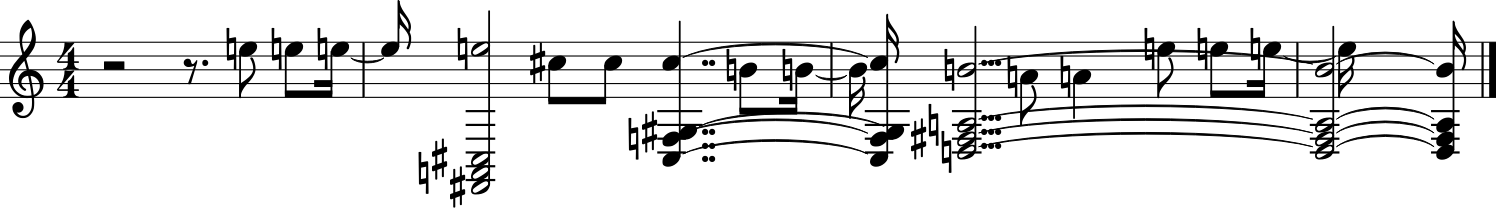

In [46]:
# Score
seed_stream.show()

**Full Sequence**

In [47]:
str2stream(' '.join(notes)).show('midi')

### Music Generation
Given the seed, we are predicting the next `n_words`.  
Temperature represents the amount of randomness. Higher = more random

In [113]:
# pred_out = seed + predictions 
pred_out = learn.predict(seed, n_words=300, temperature=1.5, min_p=0.05); pred_out

'|| t10 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 || t5 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 || t5 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 xxbos || t0 nF3 t16 nA3 t16 nC4 t16 nC5 t1 || t1 nC5 t1 || t0 nC5 t1 || t0 nC5 t1 || t0 nD5 t1 || t1 nC5 t3 || t8 nG2 t16 nB2 t16 nD3 t16 nB4 t2 || t1 nB4 t1 || t0 nB4 t1 || t0 nB4 t2 || t1 nA4 t1 || t0 nG4 t2 || t1 nB4 t2 || 

In [114]:
# pred_only = predictions (without seed)
pred_only = pred_out.replace(seed, '').strip(); pred_only

'nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 || t5 nE5 t2 || t1 nE5 t2 || t1 nE5 t2 || t1 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nF#2 t8 nA2 t8 nC#3 t8 nE5 t4 || t3 nC#5 t2 || t1 nC#5 t2 || t1 nC#3 t8 nF3 t8 nG#3 t8 nC#5 t4 || t3 nB4 t2 || t1 nB4 t2 || t1 nD3 t24 nF#3 t24 nA3 t24 nB4 t2 || t1 nA4 t2 || t1 nA4 t4 xxbos || t0 nF3 t16 nA3 t16 nC4 t16 nC5 t1 || t1 nC5 t1 || t0 nC5 t1 || t0 nC5 t1 || t0 nD5 t1 || t1 nC5 t3 || t8 nG2 t16 nB2 t16 nD3 t16 nB4 t2 || t1 nB4 t1 || t0 nB4 t1 || t0 nB4 t2 || t1 nA4 t1 || t0 nG4 t2 || t1 nB4 t2 || t1 nA4 t2 || t1 nG4 t1 || t0 nG4 t2 || t1 nA2 t16 nC3 t16 nE3 t16 nC5 t1 || t1 nC5 t1 || t0 nC5 t1 || t0 nC5 t1 || t0 nD5 t1 || t1 nC5 t3 || t8 nD3 t8 nF3 t8 nA3 t8 nF5 t2 || t1 nF5 t1 || t0 nF5 t1 || t0 nF5 t2 || t1 nE5 t1 || t0 nD5 t2 || t0 nG2 t8 nB2 t8 nD3 t8 || t0 nC5 t1

**Prediction only**

In [115]:
prediction_stream = str2stream(pred_only)
prediction_stream.show('midi')

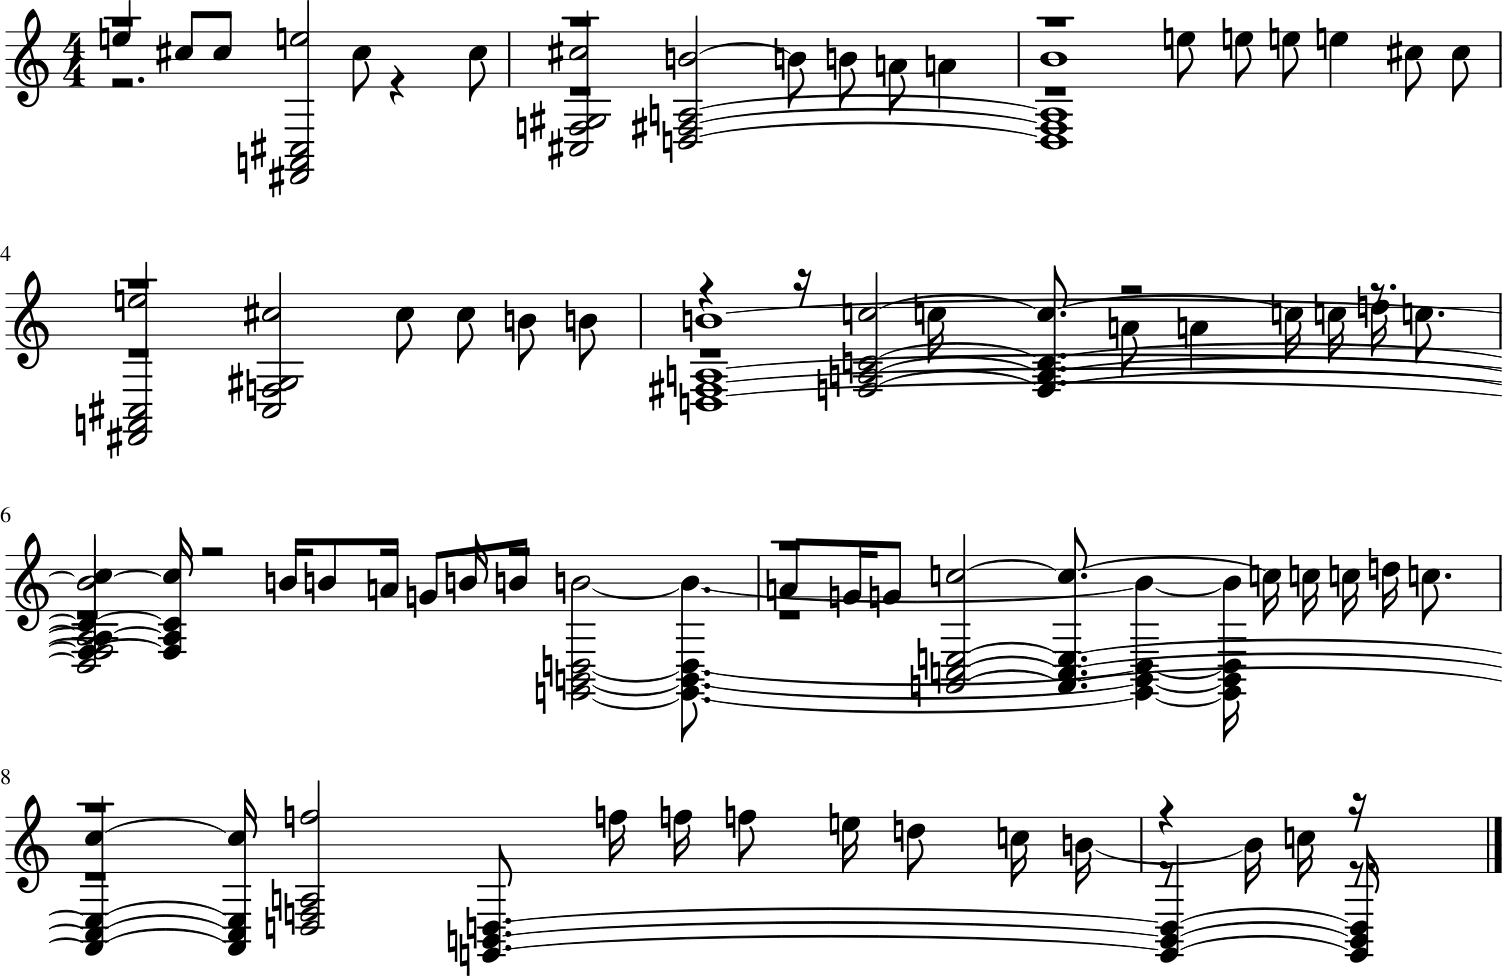

In [116]:
prediction_stream.show()

**Prediction with seed**  
Listen to the seed plus the predictions

In [117]:
full_stream = str2stream(pred_out)
full_stream.show('midi')

### Done. Repeat.
If you run the same `learn.predict` code again, you should get new predictions.  
Often, it takes a couple times to get a good output

## Beam Search

In [118]:
# pred_out = seed + predictions 
pred_out = learn.beam_search(seed, n_words=300, temperature=1.5); pred_out

RuntimeError: CUDA out of memory. Tried to allocate 444.25 MiB (GPU 0; 15.75 GiB total capacity; 12.85 GiB already allocated; 358.88 MiB free; 1.21 GiB cached)

In [ ]:
# pred_only = predictions (without seed)
pred_only = pred_out.replace(seed, '').strip(); pred_only

In [ ]:
prediction_stream = str2stream(pred_only)
prediction_stream.show('midi')

In [ ]:
prediction_stream.show()